In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.4.0
TFP version: 0.11.0


# Variational autoencoders

## Coding tutorials

#### [1. Encoders and decoders](#tutorial1)
#### [2. Minimising Kullback-Leibler divergence](#tutorial2)
#### [3. Maximising the ELBO](#tutorial3)
#### [4. KL divergence layers](#tutorial4)

***
<a class="anchor" id="tutorial1"></a>
## Encoders and decoders

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load Fashion MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

4423680/4422102 [==============================] - 0s 0us/step


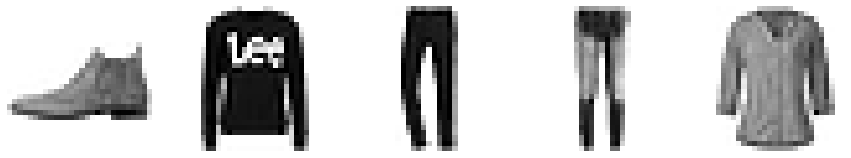

In [4]:
# Display a few examples

n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [5]:
# Define the encoder

encoding_dims = 2
input_shape = (28, 28)

def ENCODER(input_shape, encoding_dims):
    model = Sequential([
                        layers.InputLayer(input_shape=input_shape),
                        layers.Reshape((*input_shape, 1)),
                        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.Flatten(),
                        layers.BatchNormalization(),
                        layers.Dense(units=encoding_dims)
    ])
    return model

In [6]:
# Encode examples before training

enc_model = ENCODER(input_shape, encoding_dims)
enc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 16)          2320      
_________________________________________________________________
flatten (Flatten)            (None, 144)               0

In [7]:
pretrain_example_encodings = enc_model(example_images).numpy()

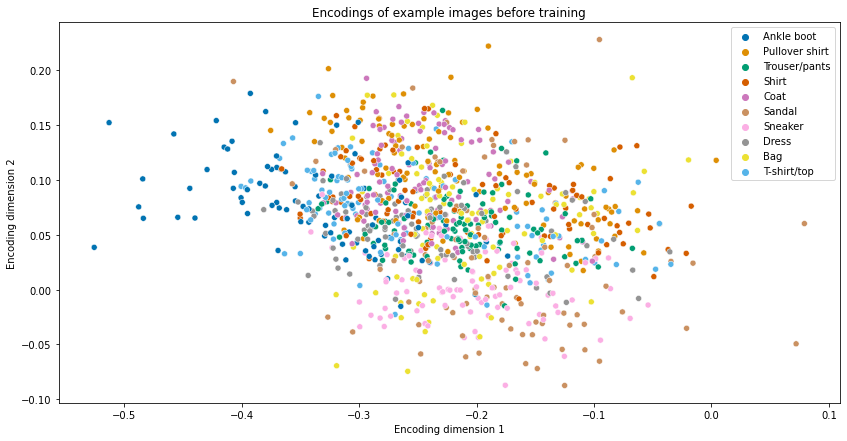

In [8]:
# Plot encoded examples before training 

f, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.scatterplot(x = pretrain_example_encodings[:, 0],
                y = pretrain_example_encodings[:, 1],
                hue = class_names[example_labels], ax=ax,
                palette = sns.color_palette("colorblind", 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

In [9]:
# Define the decoder

def DECODER(encoding_dims, target_shape):
    model = Sequential([
                        layers.InputLayer(input_shape=(encoding_dims,)),
                        layers.Dense(units=8, activation="relu"),
                        layers.Dense(units=32, activation="relu"),
                        layers.Dense(units=64, activation="relu"),
                        layers.Dense(units=128, activation="relu"),
                        layers.Dense(units=np.prod(target_shape), activation="sigmoid"),
                        layers.Reshape(target_shape)
    ])
    return model

In [10]:
dec_model = DECODER(encoding_dims, input_shape)
dec_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 111,880
Trainable params: 111,880
Non-trainable params: 0
________________________________________________

In [11]:
mse = losses.MeanSquaredError(name="mse")
bce = losses.BinaryCrossentropy(name="bce")
map = losses.MeanAbsoluteError(name="map")

def loss(y_true, y_pred):
    return 0.3333*mse(y_true, y_pred) + 0.3333*bce(y_true, y_pred) + 0.3333*map(y_true, y_pred)

In [12]:
# Compile and fit the model
autoencoder = Model(inputs=enc_model.inputs, outputs = dec_model(enc_model.outputs))

# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss
autoencoder.compile(loss=loss, optimizer=optimizers.Adam())

# Fit model - highlight that labels and input are the same
autoencoder.fit(x=x_train, y=x_train, epochs=20, batch_size=100)

Epoch 1/20
600/600 [==============================] - 3s 3ms/step - loss: 0.2251
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1682
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1642
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1622
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1601
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1591
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1580
Epoch 8/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1566
Epoch 9/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1565
Epoch 10/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1555
Epoch 11/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1556
Epoch 12/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1561
Epoch 13/20
600/600 [====

In [13]:
# Compute example encodings after training

posttrain_example_encodings = enc_model(example_images).numpy()

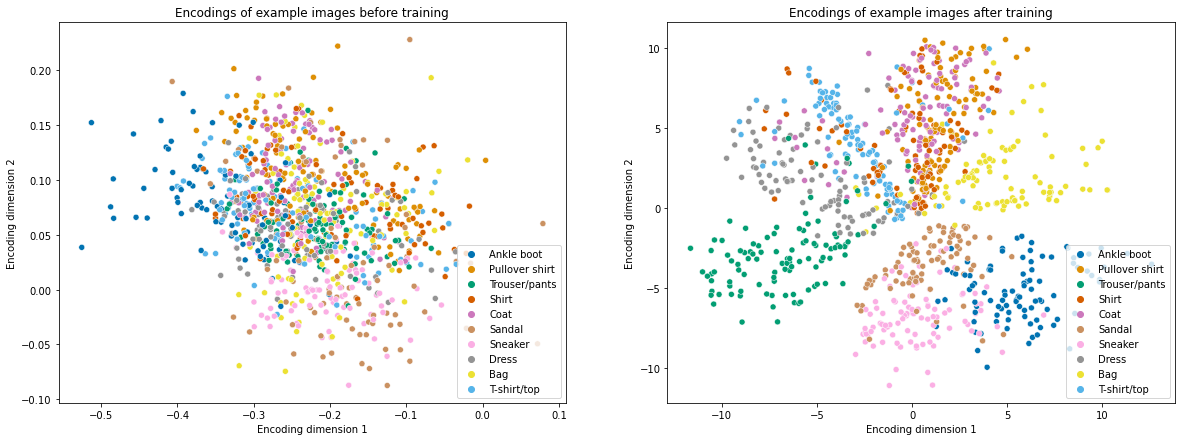

In [14]:
# Compare the example encodings before and after training

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.scatterplot(x = pretrain_example_encodings[:, 0],
                y = pretrain_example_encodings[:, 1],
                hue = class_names[example_labels], ax=axs[0],
                palette = sns.color_palette("colorblind", 10));
sns.scatterplot(x = posttrain_example_encodings[:, 0],
                y = posttrain_example_encodings[:, 1],
                hue = class_names[example_labels], ax=axs[1],
                palette = sns.color_palette("colorblind", 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')

In [15]:
# Compute the autoencoder's reconstructions

reconstructed_example_images = autoencoder(example_images).numpy()

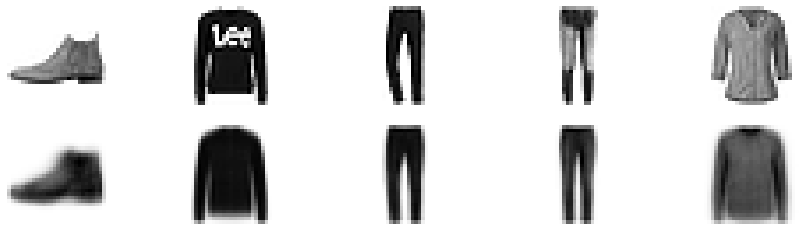

In [16]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

***
<a class="anchor" id="tutorial2"></a>
## Minimising Kullback-Leibler divergence

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

seed = 41

In [18]:
# Define a target distribution, p

tf.random.set_seed(seed)

p_mu = [0., 0.]
p_lt = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                  tfb.FillTriangular()])(tf.random.normal([3]))

p = tfd.MultivariateNormalTriL(loc = p_mu, scale_tril=p_lt)

In [19]:
# Initialize an approximating distribution, q, that has diagonal covariance

tf.random.set_seed(seed)

q = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.uniform([2])), 
                               scale_diag = tfp.util.TransformedVariable(initial_value = tf.random.uniform([2]), 
                                                                         bijector = tfb.Exp()))

In [20]:
# Function to Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

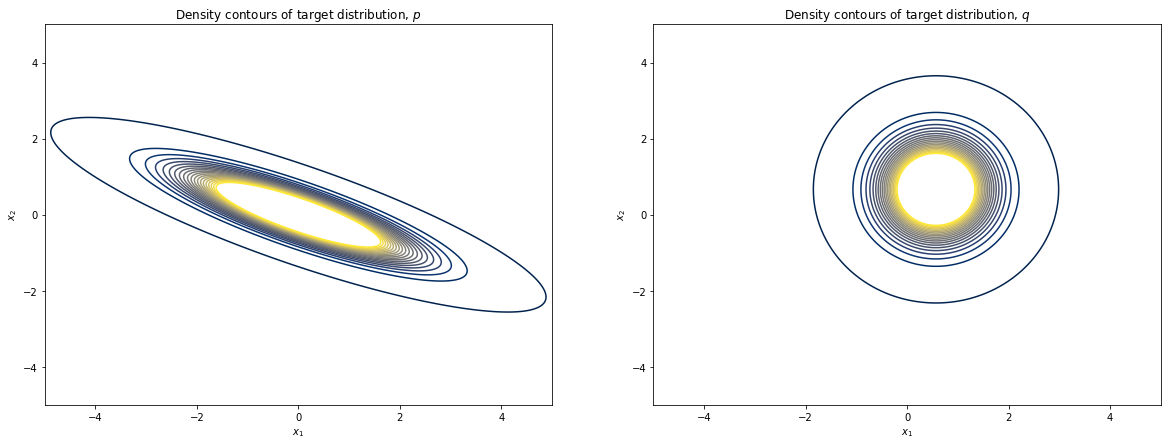

In [21]:
x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed

# Common Figure for both densities
f, ax = plt.subplots(1, 2, figsize=(20, 7))

# Density of P
ax[0] = plot_density_contours(p.prob, X1, X2, 
                              {'levels':contour_levels, 'cmap':'cividis'}, 
                              ax=ax[0])
ax[0].set_xlim(-5, 5) 
ax[0].set_ylim(-5, 5) 
ax[0].set_title('Density contours of target distribution, $p$')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')

# Density of Q
ax[1] = plot_density_contours(q.prob, X1, X2, 
                              {'levels':contour_levels, 'cmap':'cividis'}, 
                              ax=ax[1])
ax[1].set_xlim(-5, 5) 
ax[1].set_ylim(-5, 5) 
ax[1].set_title('Density contours of target distribution, $q$')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$');

In [22]:
# Define a function for the Kullback-Leibler divergence

@tf.function
def loss_and_grads(dist_q, dist_p):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_q, dist_p)
    
    return loss, tape.gradient(loss, dist_q.trainable_variables)

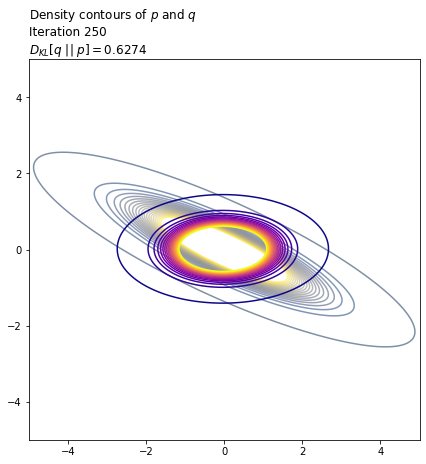

In [23]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)

for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

In [24]:
# Re-fit the distribution, this time fitting q_rev by minimising KL[p || q_rev]

tf.random.set_seed(seed)

q_rev = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.uniform([2])), 
                               scale_diag = tfp.util.TransformedVariable(initial_value = tf.random.uniform([2]), 
                                                                         bijector = tfb.Exp()))

In [25]:
# Edit loss_and_grads function

@tf.function
def loss_and_grads_rev(dist_q, dist_p):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_p, dist_q)
    
    return loss, tape.gradient(loss, dist_q.trainable_variables)

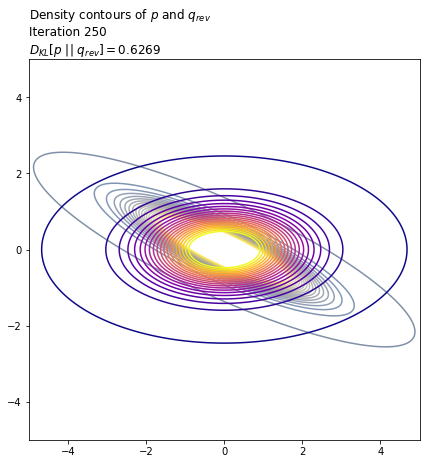

In [26]:
# Re-initialize optimizer, run training loop

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads_rev(q_rev, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

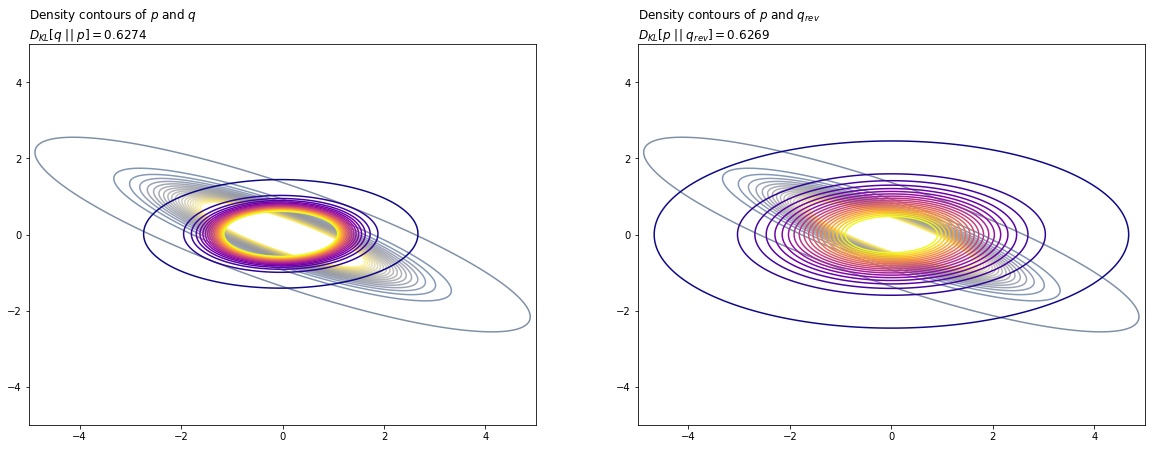

In [27]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

---
<a class="anchor" id="tutorial3"></a>
## Maximising the ELBO 

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

\begin{align}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[−\log q(Z | x) + \log p(x, Z)\big]\\
          &= - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] + \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big] 
\end{align}

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [30]:
# Define the encoding distribution, q(z|x)

latent_dim = 2
event_shape = (28, 28)

def PROB_ENCODER(event_shape, latent_dim):
    model = Sequential([
                        layers.InputLayer(input_shape=event_shape),
                        layers.Reshape((*event_shape, 1)),
                        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.Flatten(),
                        layers.Dense(units=2*latent_dim),
                        tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc = t[..., :latent_dim],
                                                                                     scale_diag =tf.exp(t[..., latent_dim:])))
    ])
    return model

In [31]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.

p_encoder = PROB_ENCODER(event_shape, latent_dim)

p_encoder(example_x)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<tfp.distributions.MultivariateNormalDiag 'sequential_2_distribution_lambda_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [32]:
# Define the decoding distribution, p(x|z)

def PROB_DECODER(latent_dim, event_shape):
    model = Sequential([
                        layers.InputLayer(input_shape=(latent_dim,)),
                        layers.Dense(units=8, activation="relu"),
                        layers.Dense(units=32, activation="relu"),
                        layers.Dense(units=64, activation="relu"),
                        layers.Dense(units=128, activation="relu"),
                        layers.Dense(units=tfpl.IndependentBernoulli.params_size(event_shape)),
                        tfpl.IndependentBernoulli(event_shape)
    ])
    return model

In [33]:
# Pass a batch of examples to the decoder

p_decoder = PROB_DECODER(latent_dim, event_shape)

p_decoder(tf.random.normal(shape=(16, 2)))

<tfp.distributions.Independent 'sequential_3_independent_bernoulli_IndependentBernoulli_Independentsequential_3_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [34]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim), scale_diag=tf.ones(latent_dim))

The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation}
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
\end{equation}

In [35]:
# Specify the loss function, an estimate of the -ELBO

def get_loss(beta):
   """
   beta = 0, Maximum Likelihood Learning
   beta = 1  Bayes Solution/Standard VAE
   beta > 1  Disentangled Representation 
   """
   loss = lambda x, encoding_dist, sampled_decoding_dist, prior: tf.reduce_sum(
       beta*tfd.kl_divergence(encoding_dist, prior) - sampled_decoding_dist.log_prob(x))
   
   return loss


loss = get_loss(1)

In [36]:
# Define a function that returns the loss and its gradients

@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = p_encoder(x)                   # P(Z|X)
        sampled_z = encoding_dist.sample()             # z ~ P(Z|X)
        sampled_decoding_dist = p_decoder(sampled_z)  # P(X|Z)
        curr_loss = loss(x, encoding_dist, sampled_decoding_dist, prior)

    grads = tape.gradient(curr_loss, p_encoder.trainable_variables+p_decoder.trainable_variables)

    return curr_loss, grads

In [37]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, p_encoder.trainable_variables
                                       + p_decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 9459
-ELBO after epoch 2: 9115
-ELBO after epoch 3: 9021
-ELBO after epoch 4: 8926
-ELBO after epoch 5: 8893


In [38]:
# Connect encoder and decoder, compute a reconstruction

def VAE(inputs, n_samples,encoder=p_encoder, decoder=p_decoder):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    
    return tf.concat(values = [decoding_dist.mode()[tf.newaxis, ...], 
                               decoding_dist.mean()[tf.newaxis, ...], 
                               decoding_dist.sample(n_samples)], 
                     axis = 0)

n_samples = 1
example_reconstruction = VAE(example_x, n_samples).numpy()

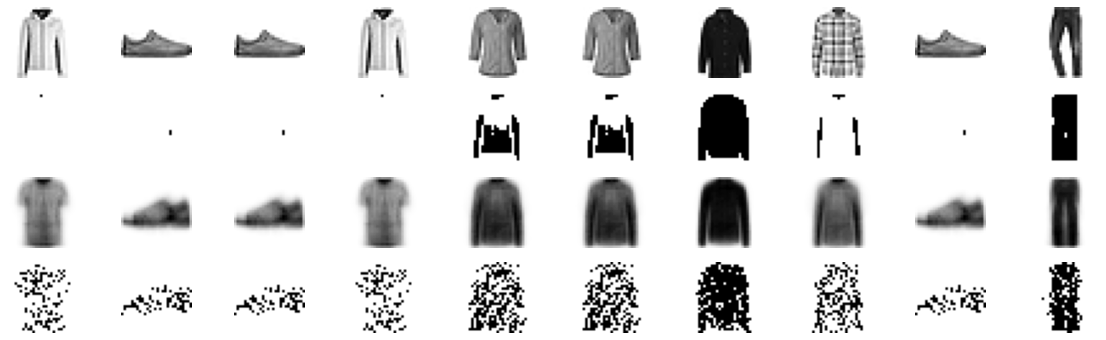

In [39]:
# Plot examples against reconstructions

"""
Original Image
Mode of Learned Distribution
Mean of Learned Distribution
Sample from a Learned Distribution.
"""

n_images = 10

f, axs = plt.subplots(n_samples+3, n_images, figsize=(20, 6))

for j in range(n_images):
    idx = np.random.randint(0, len(example_x))
    axs[0, j].imshow(example_x[idx, :, :].squeeze(), cmap='binary')
    axs[0, j].axis('off')
    for i in range(n_samples+2):
      axs[1+i, j].imshow(example_reconstruction[i, idx, :, :], cmap='binary')
      axs[1+i, j].axis('off')

In [40]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = p_decoder(z).mean()

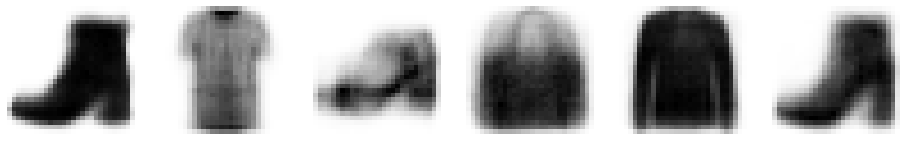

In [41]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [42]:
# -ELBO estimate using an estimate of the KL divergence

def loss(x, encoding_dist, sampled_decoding_dist,
         prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z)
                    - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + recon_loss)

***
<a class="anchor" id="tutorial4"></a>
# KL divergence layers

In [43]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Import Fashion MNIST

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256. + 0.5/256
example_x = x_test[:16]

batch_size = 32
x_train = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)
x_test = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

In [45]:
# Define latent_size and the prior, p(z)

latent_size = 4

prior = tfd.MultivariateNormalDiag(loc=tf.zeros((latent_size,)), scale_diag=tf.ones((latent_size,)))

In [46]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer

event_shape = (28, 28)

def PROB_ENCODER(event_shape, latent_dim, kl_layer = tfpl.KLDivergenceAddLoss(prior)):
    model = Sequential([
                        layers.InputLayer(input_shape=event_shape),
                        layers.Reshape((*event_shape, 1)),
                        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.MaxPool2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"),
                        layers.Flatten(),
                        layers.Dense(units=tfpl.MultivariateNormalTriL.params_size(latent_size)),
                        tfpl.MultivariateNormalTriL(latent_size),
                        kl_layer # estimate KL(q(z|x) || p(x))
    ])
    return model

# samples x_j from q(x | x_j)
# then compute log q(x_j | x_j) - log p(x_j)

encoder = PROB_ENCODER(event_shape, latent_size)

In [47]:
# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs

encoder.losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [48]:
# Pass a batch of images through the encoder

encoder(example_x)

<tfp.distributions.MultivariateNormalTriL 'sequential_4_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[4] dtype=float32>

In [49]:
# See how encoder.losses has changed

encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.4742848>]

In [50]:
# Re-specify the encoder using `weight` and `test_points_fn`

kl_layer = tfpl.KLDivergenceAddLoss(prior, 
                                    use_exact_kl=False, 
                                    weight=1.5, 
                                    test_points_fn=lambda q: q.sample(10),
                                    test_points_reduce_axis = 0)

#(n_samples, batch_size, event_size)
encoder = PROB_ENCODER(event_shape, latent_size, kl_layer)

In [51]:
# Replacing `KLDivergenceAddLoss`  with `KLDivergenceRegularizer` in the previous (probabilistic) layer

# Pass kl_layer as activity regularizer in the last Dense layer of the Encoder.

In [52]:
# Specify the decoder, p(x|z)

decoder = Sequential([
    Dense(16, activation='sigmoid', input_shape=(latent_size,)),
    Dense(32, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(2*event_shape[0]*event_shape[1], activation='exponential'),
    Reshape((event_shape[0], event_shape[1], 2)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., 0],
                     concentration0=t[..., 1])
        )
    )
])

In [53]:
# Connect the encoder and decoder to form the VAE

vae = Model(inputs = encoder.inputs, outputs=decoder(encoder.outputs))

In [54]:
# Define a loss that only estimates the expected reconstruction error,
# -E_{Z ~ q(z|x)}[log p(x|Z)]

def log_loss(x_true, p_x_given_z):
    return -tf.reduce_sum(p_x_given_z.log_prob(x_true))

In [55]:
# Compile and fit the model

vae.compile(loss = log_loss, optimizer=optimizers.Adam())

vae.fit(x_train, validation_data=x_test, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: -38909.2868 - val_loss: -45601.9219
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: -46649.5498 - val_loss: -50820.8789
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: -51074.4030 - val_loss: -53815.3008
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: -54091.1416 - val_loss: -56532.2227
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: -58787.0610 - val_loss: -60298.9492
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: -60350.4110 - val_loss: -59873.7969
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: -61240.0381 - val_loss: -61085.4023
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: -62650.5712 - val_loss: -53997.6562
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 16392.3411 - val_lo

In [56]:
# Generate an example reconstruction

example_reconstruction = vae(example_x).mean().numpy()

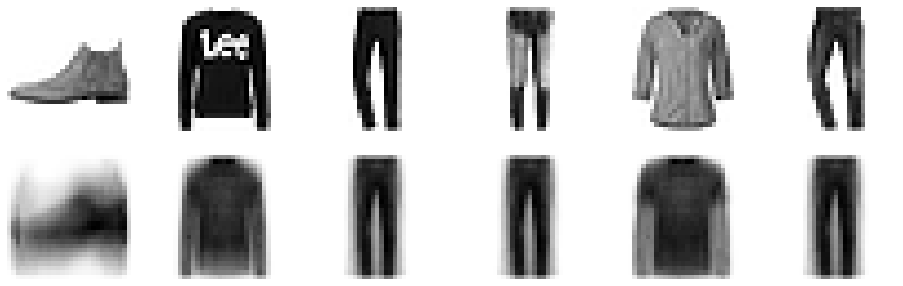

In [57]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')